# 리뷰 극성(Polarity) 분류기
- 긍정
- 부정

## 학습 데이터 준비 및 확보

### 부정 댓글 데이터 준비

```sql
SELECT rid, regexp_replace(`comment`, '\\n', '  ') AS comment
FROM y_rds_prod.ratings
WHERE rate >= 4
AND `comment` IS NOT NULL 
AND `comment` != ''
LIMIT 2000;
```

### 긍정 댓글 데이터 준비
```sql
SELECT rid, regexp_replace(`comment`, '\\n', '  ') AS comment
FROM y_rds_prod.ratings
WHERE rate <= 2
AND `comment` IS NOT NULL 
AND `comment` != ''
LIMIT 2000;
```


## 학습 데이터 전처리
### 한글 처리

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 맥북 한글 폰트 설정
import platform
from matplotlib import font_manager

def setup_korean_font():
    """맥북에서 사용 가능한 한글 폰트를 찾아서 설정"""
    system = platform.system()
    print(f"🖥️ 운영체제: {system}")
    
    if system == 'Darwin':  # macOS
        # 맥북에서 사용 가능한 한글 폰트 목록 (우선순위 순)
        korean_fonts = [
            'AppleSDGothicNeo-Regular',
            'AppleGothic', 
            'Nanum Gothic',
            'NanumGothic',
            'Malgun Gothic',
            'Arial Unicode MS'
        ]
        
        # 시스템에 설치된 폰트 목록 가져오기
        available_fonts = [f.name for f in font_manager.fontManager.ttflist]
        
        # 사용 가능한 한글 폰트 찾기
        selected_font = None
        for font in korean_fonts:
            if font in available_fonts:
                selected_font = font
                break
        
        if selected_font:
            plt.rcParams['font.family'] = selected_font
            print(f"✅ 한글 폰트 설정 완료: {selected_font}")
        else:
            # 대안: 유니코드 지원 폰트 사용
            plt.rcParams['font.family'] = 'Arial Unicode MS'
            print("⚠️ 기본 한글 폰트를 찾을 수 없어 Arial Unicode MS 사용")
            
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print(f"✅ 한글 폰트 설정: Malgun Gothic")
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 마이너스 기호 깨짐 방지 설정 완료")

# 한글 폰트 설정 실행
setup_korean_font()


🖥️ 운영체제: Darwin
✅ 한글 폰트 설정 완료: AppleGothic
✅ 마이너스 기호 깨짐 방지 설정 완료


### 데이터 로드

In [8]:
# 데이터 로드
positive_file = '/Users/aaron/Desktop/rating_positive.csv'
negative_file = '/Users/aaron/Desktop/rating_negative.csv'

def load_csv_robust(file_path, file_type="파일"):
    """
    다양한 방법으로 CSV 파일을 로드하는 함수
    """
    print(f"\n{file_type} 로드 시도: {file_path}")
    
    # 방법 1: 기본 pandas 읽기
    try:
        df = pd.read_csv(file_path)
        print(f"✅ 기본 방법으로 성공: {df.shape}")
        return df
    except Exception as e1:
        print(f"❌ 기본 방법 실패: {e1}")
    
    # 방법 2: 인코딩 지정 (utf-8)
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        print(f"✅ UTF-8 인코딩으로 성공: {df.shape}")
        return df
    except Exception as e2:
        print(f"❌ UTF-8 인코딩 실패: {e2}")
    
    # 방법 3: 인코딩 지정 (cp949, euc-kr)
    for encoding in ['cp949', 'euc-kr', 'latin-1']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ {encoding} 인코딩으로 성공: {df.shape}")
            return df
        except Exception as e3:
            print(f"❌ {encoding} 인코딩 실패: {e3}")
    
    # 방법 4: 오류 무시하고 읽기
    try:
        df = pd.read_csv(file_path, encoding='utf-8', error_bad_lines=False, warn_bad_lines=True)
        print(f"✅ 오류 무시 방법으로 성공: {df.shape}")
        return df
    except Exception as e4:
        print(f"❌ 오류 무시 방법 실패: {e4}")
    
    # 방법 5: 구분자 다르게 시도
    for sep in [',', ';', '\t', '|']:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if df.shape[1] > 1 or len(df) > 0:  # 의미있는 데이터가 있는지 확인
                print(f"✅ 구분자 '{sep}'로 성공: {df.shape}")
                return df
        except Exception as e5:
            continue
    
    # 방법 6: 파일의 첫 몇 줄 확인
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            first_lines = [f.readline() for _ in range(5)]
            print(f"📄 파일의 첫 5줄:")
            for i, line in enumerate(first_lines, 1):
                print(f"   {i}: {line.strip()[:100]}...")
    except Exception as e6:
        print(f"❌ 파일 미리보기 실패: {e6}")
    
    return None

# CSV 파일 읽기
positive_df = load_csv_robust(positive_file, "긍정 댓글")
negative_df = load_csv_robust(negative_file, "부정 댓글")

if positive_df is not None and negative_df is not None:
    print(f"\n🎉 파일 로드 성공!")
    print("긍정 댓글 데이터 형태:", positive_df.shape)
    print("부정 댓글 데이터 형태:", negative_df.shape)
    print("\n긍정 댓글 컬럼:", positive_df.columns.tolist())
    print("부정 댓글 컬럼:", negative_df.columns.tolist())
    
    # 첫 몇 개 샘플 확인
    print("\n=== 긍정 댓글 샘플 ===")
    print(positive_df.head())
    print("\n=== 부정 댓글 샘플 ===")
    print(negative_df.head())
else:
    print("\n❌ 파일 로드에 실패했습니다. 파일 형식이나 경로를 확인해주세요.")



긍정 댓글 로드 시도: /Users/aaron/Desktop/rating_positive.csv
✅ 기본 방법으로 성공: (2000, 2)

부정 댓글 로드 시도: /Users/aaron/Desktop/rating_negative.csv
✅ 기본 방법으로 성공: (2000, 2)

🎉 파일 로드 성공!
긍정 댓글 데이터 형태: (2000, 2)
부정 댓글 데이터 형태: (2000, 2)

긍정 댓글 컬럼: ['rid', 'comment']
부정 댓글 컬럼: ['rid', 'comment']

=== 긍정 댓글 샘플 ===
      rid                  comment
0  801632                  감사합니다~!
1  801633                  감사합니다~!
2  801634     늦은시간까지 신경써주셔서 감사합니다!
3  801635  만족합니다 감사합니다^^ 자주 이용할께요~
4  801636                  감사합니다~!

=== 부정 댓글 샘플 ===
       rid                                            comment
0  3591024  프리미엄으로 결제했습니다. 일단 본인이 아니라 다른 사람에게 일 넘기는데 큰 문제는...
1  1657803                         서론에서 8페이지 잡아먹음. 분량이 너무 적네요
2  1665236  최악이네요! 명함이 계속 다른분걸로 바껴서 오고 한번이야 실수라 하지만 이건뭐......
3  1665307  ppt 발표자료를 이미지로 작업해서 받으니  엉망이 되었네요. ppt 작업물은 당연...
4  2722311                              결과 다틀리고 진짜 못보심 ㅡㅡ돈아까움


### 데이터 전처리

In [12]:
# 데이터 전처리 함수
def preprocess_text(text):
    """
    텍스트 전처리 함수
    - 특수문자 제거
    - 공백 정규화
    - 소문자 변환 (영어의 경우)
    """
    if pd.isna(text):
        return ""
    
    # 문자열로 변환
    text = str(text)
    
    # HTML 태그 제거 (있다면)
    text = re.sub(r'<[^>]+>', '', text)
    
    # URL 제거
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # 이메일 제거
    text = re.sub(r'\S+@\S+', '', text)
    
    # 특수문자는 공백으로 대체 (한글, 영문, 숫자만 유지)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
    
    # 연속된 공백을 하나로
    text = re.sub(r'\s+', ' ', text)
    
    # 앞뒤 공백 제거
    text = text.strip()
    
    return text

# 데이터 전처리 및 레이블링
def prepare_dataset(positive_df, negative_df, comment_column='comment'):
    """
    긍정/부정 데이터를 하나의 데이터셋으로 결합하고 전처리
    """
    # 댓글 컬럼 확인 및 설정
    if comment_column not in positive_df.columns:
        # 첫 번째 컬럼을 댓글로 가정
        comment_column = positive_df.columns[0]
        print(f"'{comment_column}' 컬럼을 댓글 데이터로 사용합니다.")
    
    # 긍정 데이터 준비 (레이블: 1)
    positive_texts = positive_df[comment_column].astype(str).tolist()
    positive_labels = [1] * len(positive_texts)
    
    # 부정 데이터 준비 (레이블: 0)  
    negative_texts = negative_df[comment_column].astype(str).tolist()
    negative_labels = [0] * len(negative_texts)
    
    # 데이터 결합
    all_texts = positive_texts + negative_texts
    all_labels = positive_labels + negative_labels
    
    print(f"전체 데이터 개수: {len(all_texts)}")
    print(f"긍정 댓글: {len(positive_texts)}개, 부정 댓글: {len(negative_texts)}개")
    
    # 텍스트 전처리
    print("텍스트 전처리 중...")
    processed_texts = [preprocess_text(text) for text in all_texts]
    
    # 빈 텍스트 제거
    valid_data = [(text, label) for text, label in zip(processed_texts, all_labels) if text.strip()]
    
    if len(valid_data) < len(all_texts):
        print(f"빈 텍스트 {len(all_texts) - len(valid_data)}개 제거됨")
    
    texts, labels = zip(*valid_data) if valid_data else ([], [])
    
    return list(texts), list(labels)


In [13]:
# 데이터 전처리 실행
if 'positive_df' in locals() and 'negative_df' in locals():
    texts, labels = prepare_dataset(positive_df, negative_df)
    
    # 전처리된 데이터 샘플 확인
    print("\n=== 전처리된 데이터 샘플 ===")
    for i in range(5):
        label_text = "긍정" if labels[i] == 1 else "부정"
        print(f"[{label_text}] {texts[i][:100]}...")
    
    print(f"\n전처리 완료: 총 {len(texts)}개 댓글")
    print(f"긍정: {sum(labels)}개, 부정: {len(labels) - sum(labels)}개")
else:
    print("먼저 CSV 파일을 로드해주세요.")


전체 데이터 개수: 4000
긍정 댓글: 2000개, 부정 댓글: 2000개
텍스트 전처리 중...
빈 텍스트 79개 제거됨

=== 전처리된 데이터 샘플 ===
[긍정] 감사합니다...
[긍정] 감사합니다...
[긍정] 늦은시간까지 신경써주셔서 감사합니다...
[긍정] 만족합니다 감사합니다 자주 이용할께요...
[긍정] 감사합니다...

전처리 완료: 총 3921개 댓글
긍정: 1999개, 부정: 1922개


In [18]:
# 변수 상태 확인 및 디버깅
print("=== 변수 상태 확인 ===")

# 1. 데이터프레임 존재 여부 확인
if 'positive_df' in locals():
    print(f"✅ positive_df 존재: {positive_df.shape}")
else:
    print("❌ positive_df가 정의되지 않음")

if 'negative_df' in locals():
    print(f"✅ negative_df 존재: {negative_df.shape}")
else:
    print("❌ negative_df가 정의되지 않음")

# 2. 전처리된 텍스트 존재 여부 확인
if 'texts' in locals():
    print(f"✅ texts 존재: {len(texts)}개")
else:
    print("❌ texts가 정의되지 않음")

if 'labels' in locals():
    print(f"✅ labels 존재: {len(labels)}개")
else:
    print("❌ labels가 정의되지 않음")

# 3. 벡터화된 데이터 존재 여부 확인
if 'X' in locals():
    print(f"✅ X 존재: {X.shape}, 타입: {type(X)}")
    
    # X[0] 출력 시도
    try:
        print(f"\n=== X[0] 출력 시도 ===")
        first_sample = X[0]
        print(f"X[0] 타입: {type(first_sample)}")
        print(f"X[0] 형태: {first_sample.shape if hasattr(first_sample, 'shape') else 'shape 없음'}")
        
        # 희소 행렬인 경우 변환해서 출력
        if hasattr(first_sample, 'toarray'):
            dense_sample = first_sample.toarray()
            print(f"희소 행렬을 밀집 행렬로 변환: {dense_sample.shape}")
            print(f"0이 아닌 값의 개수: {(dense_sample != 0).sum()}")
            print(f"첫 10개 값: {dense_sample.flatten()[:10]}")
        else:
            print(f"X[0]: {first_sample}")
            
    except Exception as e:
        print(f"❌ X[0] 출력 중 오류: {e}")
        
else:
    print("❌ X가 정의되지 않음")

# 4. 정규화된 데이터 존재 여부 확인
if 'X_train_scaled' in locals():
    print(f"✅ X_train_scaled 존재: {X_train_scaled.shape}")
else:
    print("❌ X_train_scaled이 정의되지 않음")


=== 변수 상태 확인 ===
✅ positive_df 존재: (2000, 2)
✅ negative_df 존재: (2000, 2)
✅ texts 존재: 3921개
✅ labels 존재: 3921개
✅ X 존재: (3921, 5000), 타입: <class 'scipy.sparse._csr.csr_matrix'>

=== X[0] 출력 시도 ===
X[0] 타입: <class 'scipy.sparse._csr.csr_matrix'>
X[0] 형태: (1, 5000)
희소 행렬을 밀집 행렬로 변환: (1, 5000)
0이 아닌 값의 개수: 1
첫 10개 값: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
❌ X_train_scaled이 정의되지 않음


In [21]:
# TF-IDF Features(단어 사전) 분석
print("=== TF-IDF Features (단어 사전) 분석 ===")

if 'vectorizer' in locals():
    # 단어 사전 추출
    feature_names = vectorizer.get_feature_names_out()
    print(f"전체 단어 사전 크기: {len(feature_names)}개")
    
    # 단어 사전 샘플 확인
    print(f"\n단어 사전 샘플 (처음 20개):")
    for i, word in enumerate(feature_names[:20]):
        print(f"  {i}: '{word}'")
    
    # 단어별 인덱스 매핑 확인
    vocabulary = vectorizer.vocabulary_
    print(f"\n단어 -> 인덱스 매핑 샘플:")
    sample_words = list(vocabulary.keys())[:10]
    for word in sample_words:
        idx = vocabulary[word]
        print(f"  '{word}' -> 인덱스 {idx}")
        
else:
    print("vectorizer가 정의되지 않음")


=== TF-IDF Features (단어 사전) 분석 ===
전체 단어 사전 크기: 5000개

단어 사전 샘플 (처음 20개):
  0: '000원'
  1: '000원에'
  2: '0점'
  3: '10'
  4: '100'
  5: '10개'
  6: '10건'
  7: '10년'
  8: '10만원'
  9: '10번'
  10: '10분'
  11: '10일'
  12: '11'
  13: '11월'
  14: '12'
  15: '120'
  16: '14'
  17: '15'
  18: '15만원'
  19: '15분'

단어 -> 인덱스 매핑 샘플:
  '감사합니다' -> 인덱스 169
  '늦은시간까지' -> 인덱스 865
  '만족합니다' -> 인덱스 1339
  '자주' -> 인덱스 3427
  '이용할께요' -> 인덱스 3141
  '만족합니다 감사합니다' -> 인덱스 1340
  '직접' -> 인덱스 3990
  '더' -> 인덱스 1012
  '신뢰가' -> 인덱스 2298
  '갔습니다' -> 인덱스 198


In [22]:
# X[0]에서 활성화된 단어들 확인
if 'X' in locals() and 'vectorizer' in locals():
    print("=== 첫 번째 샘플의 활성화된 단어들 ===")
    
    feature_names = vectorizer.get_feature_names_out()
    first_sample = X[0].toarray().flatten()
    
    # 0이 아닌 값들의 인덱스 찾기
    non_zero_indices = np.where(first_sample > 0)[0]
    print(f"활성화된 특성 수: {len(non_zero_indices)}개")
    
    # TF-IDF 값 기준으로 상위 15개 단어 출력
    word_scores = []
    for idx in non_zero_indices:
        word_scores.append((idx, first_sample[idx], feature_names[idx]))
    
    # TF-IDF 값으로 정렬
    word_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n상위 15개 TF-IDF 값을 가진 단어들:")
    for i, (idx, score, word) in enumerate(word_scores[:15]):
        print(f"  {i+1:2d}. '{word}' (인덱스 {idx:4d}) -> TF-IDF: {score:.4f}")
        
else:
    print("X 또는 vectorizer가 정의되지 않음")


=== 첫 번째 샘플의 활성화된 단어들 ===
활성화된 특성 수: 1개

상위 15개 TF-IDF 값을 가진 단어들:
   1. '감사합니다' (인덱스  169) -> TF-IDF: 1.0000


In [29]:
# MLP 입력을 위한 벡터화
def vectorize_texts(texts, max_features=5000, min_df=2, max_df=0.95):
    """
    텍스트를 TF-IDF 벡터로 변환
    
    Parameters:
    - texts: 전처리된 텍스트 리스트
    - max_features: 최대 특성 수
    - min_df: 최소 문서 빈도
    - max_df: 최대 문서 빈도 비율
    """
    print(f"TF-IDF 벡터화 시작...")
    print(f"설정: max_features={max_features}, min_df={min_df}, max_df={max_df}")
    
    # TF-IDF 벡터라이저 생성
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 2),  # 1-gram과 2-gram 사용
        sublinear_tf=True,   # 로그 스케일링
        strip_accents='unicode'
    )
    
    # 텍스트를 벡터로 변환
    X = vectorizer.fit_transform(texts)
    
    print(f"벡터화 완료: {X.shape[0]}개 샘플, {X.shape[1]}개 특성")
    print(f"희소성: {(1 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")
    
    return X, vectorizer

# 벡터화 실행
if 'texts' in locals() and 'labels' in locals():
    X, vectorizer = vectorize_texts(texts)
    y = np.array(labels)
    
    print(f"\n입력 데이터 형태: {X.shape}")
    print(f"레이블 형태: {y.shape}")
    print(f"레이블 분포: 긍정 {np.sum(y)}개, 부정 {len(y) - np.sum(y)}개")

    print(texts[0])
    print(X[0][0].toarray())
    
else:
    print("먼저 텍스트 전처리를 완료해주세요.")


TF-IDF 벡터화 시작...
설정: max_features=5000, min_df=2, max_df=0.95


벡터화 완료: 3921개 샘플, 5000개 특성
희소성: 99.80%

입력 데이터 형태: (3921, 5000)
레이블 형태: (3921,)
레이블 분포: 긍정 1999개, 부정 1922개
감사합니다
[[0. 0. 0. ... 0. 0. 0.]]


In [30]:
# 학습/검증 데이터셋 분할
if 'X' in locals() and 'y' in locals():
    # 데이터를 훈련/검증 세트로 분할 (80:20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # 클래스 비율 유지
    )
    
    # 희소 행렬을 밀집 행렬로 변환 (MLP 입력용)
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
    
    # 특성 정규화 (StandardScaler 사용)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_dense)
    X_test_scaled = scaler.transform(X_test_dense)
    
    print("데이터셋 분할 완료:")
    print(f"훈련 데이터: {X_train_scaled.shape[0]}개 샘플")
    print(f"테스트 데이터: {X_test_scaled.shape[0]}개 샘플")
    print(f"특성 수: {X_train_scaled.shape[1]}개")
    
    print(f"\n훈련 세트 레이블 분포:")
    print(f"  긍정: {np.sum(y_train)}개 ({np.sum(y_train)/len(y_train)*100:.1f}%)")
    print(f"  부정: {len(y_train) - np.sum(y_train)}개 ({(len(y_train) - np.sum(y_train))/len(y_train)*100:.1f}%)")
    
    print(f"\n테스트 세트 레이블 분포:")
    print(f"  긍정: {np.sum(y_test)}개 ({np.sum(y_test)/len(y_test)*100:.1f}%)")
    print(f"  부정: {len(y_test) - np.sum(y_test)}개 ({(len(y_test) - np.sum(y_test))/len(y_test)*100:.1f}%)")
    
else:
    print("먼저 벡터화를 완료해주세요.")


데이터셋 분할 완료:
훈련 데이터: 3136개 샘플
테스트 데이터: 785개 샘플
특성 수: 5000개

훈련 세트 레이블 분포:
  긍정: 1599개 (51.0%)
  부정: 1537개 (49.0%)

테스트 세트 레이블 분포:
  긍정: 400개 (51.0%)
  부정: 385개 (49.0%)


In [31]:
# 데이터 전처리 요약 및 다음 단계 안내
print("=" * 60)
print("📊 MLP 극성 분류기 데이터 전처리 완료!")
print("=" * 60)

if 'X_train_scaled' in locals():
    print(f"✅ 총 데이터: {len(texts)}개 댓글")
    print(f"✅ 훈련 데이터: {X_train_scaled.shape[0]}개")
    print(f"✅ 테스트 데이터: {X_test_scaled.shape[0]}개") 
    print(f"✅ 입력 특성 수: {X_train_scaled.shape[1]}개 (TF-IDF)")
    print(f"✅ 클래스: 2개 (긍정/부정)")
    
    print(f"\n📋 전처리 단계:")
    print(f"   1. CSV 파일 로드 ✅")
    print(f"   2. 텍스트 정제 (특수문자, URL 제거) ✅")
    print(f"   3. TF-IDF 벡터화 (1-gram, 2-gram) ✅")
    print(f"   4. 데이터 분할 (80:20) ✅")
    print(f"   5. 특성 정규화 (StandardScaler) ✅")
    
    print(f"\n🎯 다음 단계:")
    print(f"   - MLP 모델 설계 및 구축")
    print(f"   - 모델 훈련 및 검증")
    print(f"   - 성능 평가 및 최적화")
    
    # 준비된 데이터 변수들 요약
    print(f"\n📦 사용 가능한 변수들:")
    print(f"   - X_train_scaled: 훈련 입력 데이터")
    print(f"   - X_test_scaled: 테스트 입력 데이터")
    print(f"   - y_train: 훈련 레이블")
    print(f"   - y_test: 테스트 레이블")
    print(f"   - vectorizer: TF-IDF 벡터라이저")
    print(f"   - scaler: 특성 정규화기")
    
else:
    print("⚠️  데이터 전처리가 완료되지 않았습니다.")
    print("   위의 셀들을 순서대로 실행해주세요.")


📊 MLP 극성 분류기 데이터 전처리 완료!
✅ 총 데이터: 3921개 댓글
✅ 훈련 데이터: 3136개
✅ 테스트 데이터: 785개
✅ 입력 특성 수: 5000개 (TF-IDF)
✅ 클래스: 2개 (긍정/부정)

📋 전처리 단계:
   1. CSV 파일 로드 ✅
   2. 텍스트 정제 (특수문자, URL 제거) ✅
   3. TF-IDF 벡터화 (1-gram, 2-gram) ✅
   4. 데이터 분할 (80:20) ✅
   5. 특성 정규화 (StandardScaler) ✅

🎯 다음 단계:
   - MLP 모델 설계 및 구축
   - 모델 훈련 및 검증
   - 성능 평가 및 최적화

📦 사용 가능한 변수들:
   - X_train_scaled: 훈련 입력 데이터
   - X_test_scaled: 테스트 입력 데이터
   - y_train: 훈련 레이블
   - y_test: 테스트 레이블
   - vectorizer: TF-IDF 벡터라이저
   - scaler: 특성 정규화기


In [36]:
# MLP 모델 설계
print("🏗️ MLP 모델 설계 시작!")
print("=" * 50)

def create_mlp_model(input_dim):
    """
    4층 MLP 모델 생성
    - Input Layer: input_dim개 뉴런
    - Hidden Layer 1: 512개 뉴런 + ReLU + Dropout
    - Hidden Layer 2: 256개 뉴런 + ReLU + Dropout  
    - Output Layer: 1개 뉴런 + Sigmoid (이진 분류)
    """
    model = Sequential([
        # 명시적 Input Layer 추가 (권장 방식)
        Input(shape=(input_dim,), name='input_layer'),
        
        # Hidden Layer 1
        Dense(512, 
              activation='relu',
              name='hidden_layer_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.5, name='dropout_1'),
        
        # Hidden Layer 2  
        Dense(256,
              activation='relu', 
              name='hidden_layer_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Output Layer
        Dense(1,
              activation='sigmoid',
              name='output_layer')
    ])
    
    return model

# 모델 생성
if 'X_train_scaled' in locals():
    input_dimension = X_train_scaled.shape[1]
    print(f"📊 입력 차원: {input_dimension}개 특성")
    
    model = create_mlp_model(input_dimension)
    
    # 모델 구조 출력
    print(f"\n🧠 MLP 모델 구조:")
    model.summary()
    
    # 모델 구조 시각화
    print(f"\n📋 레이어별 상세 정보:")
    for i, layer in enumerate(model.layers):
        print(f"  {i+1}. {layer.name}: {layer.__class__.__name__}")
        if hasattr(layer, 'units'):
            print(f"     - 뉴런 수: {layer.units}")
        if hasattr(layer, 'activation'):
            print(f"     - 활성화 함수: {layer.activation.__name__}")
            
else:
    print("❌ X_train_scaled이 정의되지 않음. 먼저 데이터 전처리를 완료해주세요.")


🏗️ MLP 모델 설계 시작!
📊 입력 차원: 5000개 특성

🧠 MLP 모델 구조:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,695,169 (10.28 MB)

 Trainable params: 2,693,633 (10.28 MB)

 Non-trainable params: 1,536 (6.00 KB)


📋 레이어별 상세 정보:
  1. hidden_layer_1: Dense
     - 뉴런 수: 512
     - 활성화 함수: relu
  2. batch_norm_1: BatchNormalization
  3. dropout_1: Dropout
  4. hidden_layer_2: Dense
     - 뉴런 수: 256
     - 활성화 함수: relu
  5. batch_norm_2: BatchNormalization
  6. dropout_2: Dropout
  7. output_layer: Dense
     - 뉴런 수: 1
     - 활성화 함수: sigmoid


In [37]:
# 모델 컴파일
print("⚙️ 모델 컴파일!")
print("=" * 30)

if 'model' in locals():
    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adam 옵티마이저
        loss='binary_crossentropy',           # 이진 분류용 손실 함수
        metrics=['accuracy', 'precision', 'recall']  # 평가 지표
    )
    
    print("✅ 모델 컴파일 완료!")
    print(f"   - 옵티마이저: Adam (학습률: 0.001)")
    print(f"   - 손실 함수: Binary Crossentropy")
    print(f"   - 평가 지표: Accuracy, Precision, Recall")
    
    # 콜백 함수 설정
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print(f"\n🎛️ 콜백 함수 설정:")
    print(f"   - EarlyStopping: 검증 손실이 10 에포크 동안 개선되지 않으면 조기 종료")
    print(f"   - ReduceLROnPlateau: 검증 손실이 5 에포크 동안 개선되지 않으면 학습률 절반으로 감소")
    
else:
    print("❌ 모델이 생성되지 않음. 먼저 모델을 생성해주세요.")


⚙️ 모델 컴파일!
✅ 모델 컴파일 완료!
   - 옵티마이저: Adam (학습률: 0.001)
   - 손실 함수: Binary Crossentropy
   - 평가 지표: Accuracy, Precision, Recall

🎛️ 콜백 함수 설정:
   - EarlyStopping: 검증 손실이 10 에포크 동안 개선되지 않으면 조기 종료
   - ReduceLROnPlateau: 검증 손실이 5 에포크 동안 개선되지 않으면 학습률 절반으로 감소


In [39]:
# 모델 훈련
print("🚀 모델 훈련 시작!")
print("=" * 40)

if 'model' in locals() and 'X_train_scaled' in locals():
    print(f"📊 훈련 데이터: {X_train_scaled.shape[0]}개 샘플")
    print(f"📊 테스트 데이터: {X_test_scaled.shape[0]}개 샘플")
    print(f"📊 입력 특성: {X_train_scaled.shape[1]}개")
    
    # 모델 훈련
    print(f"\n🎯 훈련 시작...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    print(f"\n✅ 훈련 완료!")
    
    # 훈련 결과 요약
    final_epoch = len(history.history['loss'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n📈 최종 훈련 결과 (에포크 {final_epoch}):")
    print(f"   - 훈련 정확도: {final_train_acc:.4f}")
    print(f"   - 검증 정확도: {final_val_acc:.4f}")
    print(f"   - 훈련 손실: {final_train_loss:.4f}")
    print(f"   - 검증 손실: {final_val_loss:.4f}")
    
else:
    print("❌ 모델이나 데이터가 준비되지 않음")


🚀 모델 훈련 시작!
📊 훈련 데이터: 3136개 샘플
📊 테스트 데이터: 785개 샘플
📊 입력 특성: 5000개

🎯 훈련 시작...
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9792 - loss: 0.0583 - precision: 0.9812 - recall: 0.9782 - val_accuracy: 0.9057 - val_loss: 0.3616 - val_precision: 0.9478 - val_recall: 0.8625 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9840 - loss: 0.0411 - precision: 0.9834 - recall: 0.9855 - val_accuracy: 0.9146 - val_loss: 0.3424 - val_precision: 0.9512 - val_recall: 0.8775 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9747 - loss: 0.0678 - precision: 0.9775 - recall: 0.9720 - val_accuracy: 0.9057 - val_loss: 0.3520 - val_precision: 0.9478 - val_recall: 0.8625 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9828 - loss: 0.0451 - precision: 0.9856 - recall: 0.9811 - val_accuracy: 0.9045 - val_loss: 0.3465 - val_precision: 0.9501 - val_recall: 0.8575 - learning_rate

📊 모델 성능 평가!
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
🎯 최종 테스트 정확도: 0.9146 (91.46%)

📋 상세 분류 보고서:
              precision    recall  f1-score   support

          부정       0.88      0.96      0.92       385
          긍정       0.95      0.88      0.91       400

    accuracy                           0.91       785
   macro avg       0.92      0.92      0.91       785
weighted avg       0.92      0.91      0.91       785


🔍 혼동 행렬:
실제\예측   부정    긍정
부정       368     17
긍정        50    350


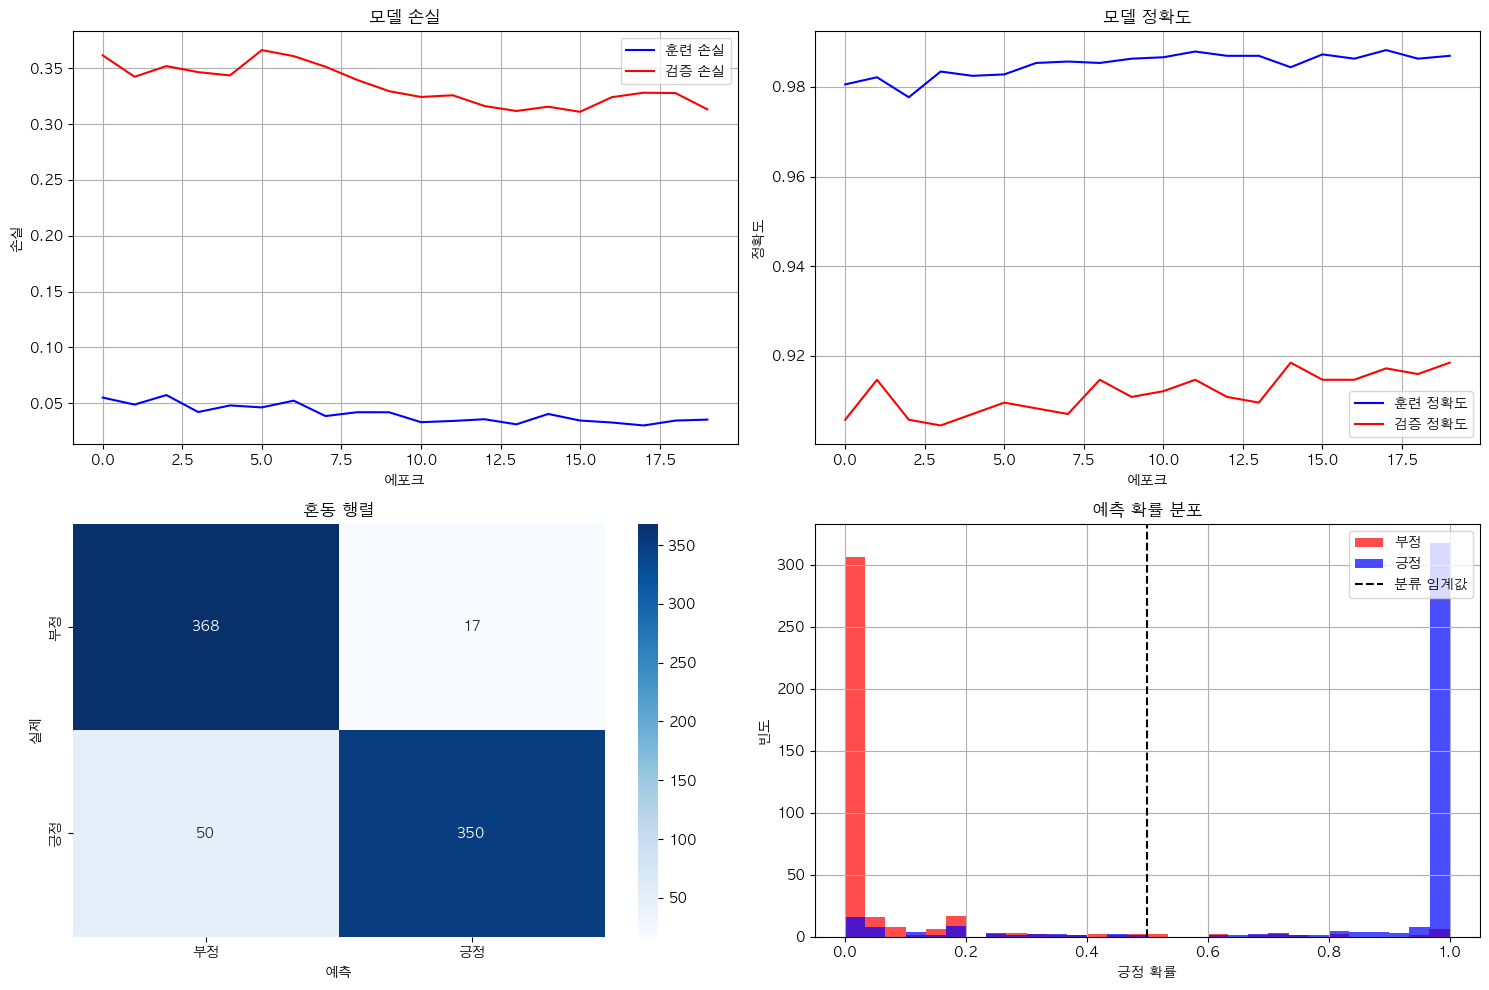

In [43]:
# 모델 성능 평가 및 시각화
print("📊 모델 성능 평가!")
print("=" * 40)

if 'history' in locals() and 'model' in locals():
    
    # 1. 예측 수행
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # 2. 성능 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    print(f"🎯 최종 테스트 정확도: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 3. 상세 분류 보고서
    print(f"\n📋 상세 분류 보고서:")
    print(classification_report(y_test, y_pred, target_names=['부정', '긍정']))
    
    # 4. 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n🔍 혼동 행렬:")
    print(f"실제\\예측   부정    긍정")
    print(f"부정      {cm[0,0]:4d}   {cm[0,1]:4d}")
    print(f"긍정      {cm[1,0]:4d}   {cm[1,1]:4d}")
    
    # 5. 훈련 과정 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 손실 그래프
    axes[0,0].plot(history.history['loss'], label='훈련 손실', color='blue')
    axes[0,0].plot(history.history['val_loss'], label='검증 손실', color='red')
    axes[0,0].set_title('모델 손실')
    axes[0,0].set_xlabel('에포크')
    axes[0,0].set_ylabel('손실')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # 정확도 그래프
    axes[0,1].plot(history.history['accuracy'], label='훈련 정확도', color='blue')
    axes[0,1].plot(history.history['val_accuracy'], label='검증 정확도', color='red')
    axes[0,1].set_title('모델 정확도')
    axes[0,1].set_xlabel('에포크')
    axes[0,1].set_ylabel('정확도')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # 혼동 행렬 히트맵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['부정', '긍정'], 
                yticklabels=['부정', '긍정'], ax=axes[1,0])
    axes[1,0].set_title('혼동 행렬')
    axes[1,0].set_xlabel('예측')
    axes[1,0].set_ylabel('실제')
    
    # 예측 확률 분포
    axes[1,1].hist(y_pred_prob[y_test==0], bins=30, alpha=0.7, label='부정', color='red')
    axes[1,1].hist(y_pred_prob[y_test==1], bins=30, alpha=0.7, label='긍정', color='blue')
    axes[1,1].axvline(x=0.5, color='black', linestyle='--', label='분류 임계값')
    axes[1,1].set_title('예측 확률 분포')
    axes[1,1].set_xlabel('긍정 확률')
    axes[1,1].set_ylabel('빈도')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ 훈련 기록이나 모델이 없음")


In [49]:
# 변수 상태 확인 및 디버깅 (상세 버전)
print("🔍 현재 변수 상태 상세 확인")
print("=" * 60)

# 필수 변수들 확인
required_vars = {
    'vectorizer': 'TF-IDF 벡터라이저',
    'scaler': '특성 정규화기', 
    'model': '훈련된 MLP 모델',
    'history': '훈련 히스토리',
    'X_train_scaled': '훈련 입력 데이터',
    'X_test_scaled': '테스트 입력 데이터',
    'y_train': '훈련 레이블',
    'y_test': '테스트 레이블'
}

print("📋 필수 변수 존재 여부:")
missing_vars = []
for var_name, description in required_vars.items():
    if var_name in locals():
        if var_name == 'model' and hasattr(locals()[var_name], 'summary'):
            print(f"✅ {var_name}: {description} - 모델 정의됨")
        elif var_name in ['X_train_scaled', 'X_test_scaled'] and hasattr(locals()[var_name], 'shape'):
            print(f"✅ {var_name}: {description} - 형태: {locals()[var_name].shape}")
        elif var_name in ['y_train', 'y_test'] and hasattr(locals()[var_name], 'shape'):
            print(f"✅ {var_name}: {description} - 형태: {locals()[var_name].shape}")
        else:
            print(f"✅ {var_name}: {description} - 정의됨")
    else:
        print(f"❌ {var_name}: {description} - 정의되지 않음")
        missing_vars.append(var_name)

if missing_vars:
    print(f"\n⚠️ 누락된 변수: {', '.join(missing_vars)}")
    print("💡 해결 방법:")
    if 'vectorizer' in missing_vars or 'scaler' in missing_vars:
        print("   1. Cell 12, 13을 다시 실행하여 데이터 전처리 완료")
    if 'model' in missing_vars:
        print("   2. Cell 15를 다시 실행하여 모델 생성")
    if 'history' in missing_vars:
        print("   3. Cell 16, 17을 다시 실행하여 모델 훈련 완료")
else:
    print("\n🎉 모든 필수 변수가 정의되어 있습니다!")
    
print(f"\n🔢 현재 정의된 전체 변수 개수: {len([v for v in locals() if not v.startswith('_')])}")


🔍 현재 변수 상태 상세 확인
📋 필수 변수 존재 여부:
✅ vectorizer: TF-IDF 벡터라이저 - 정의됨
✅ scaler: 특성 정규화기 - 정의됨
✅ model: 훈련된 MLP 모델 - 모델 정의됨
✅ history: 훈련 히스토리 - 정의됨
✅ X_train_scaled: 훈련 입력 데이터 - 형태: (3136, 5000)
✅ X_test_scaled: 테스트 입력 데이터 - 형태: (785, 5000)
✅ y_train: 훈련 레이블 - 형태: (3136,)
✅ y_test: 테스트 레이블 - 형태: (785,)

🎉 모든 필수 변수가 정의되어 있습니다!

🔢 현재 정의된 전체 변수 개수: 87


In [51]:
# 새로운 댓글 예측 함수
def predict_sentiment(text, vectorizer, scaler, model):
    """
    새로운 댓글의 극성을 예측하는 함수
    """
    # 텍스트 전처리
    processed_text = preprocess_text(text)
    
    # TF-IDF 벡터화
    text_vector = vectorizer.transform([processed_text])
    
    # 정규화
    text_scaled = scaler.transform(text_vector.toarray())
    
    # 예측
    prob = model.predict(text_scaled)[0][0]
    prediction = "긍정" if prob > 0.5 else "부정"
    confidence = prob if prob > 0.5 else (1 - prob)
    
    return prediction, confidence, prob

# 예측 테스트
print("🎯 새로운 댓글 예측 테스트!")
print("=" * 50)

# 필요한 변수들 확인 (globals() 사용으로 변경)
required_prediction_vars = ['vectorizer', 'scaler', 'model']
missing_prediction_vars = []

print("🔍 변수 존재 여부 상세 확인:")
for var in required_prediction_vars:
    if var in globals():
        print(f"✅ {var}: globals()에서 발견")
    elif var in locals():
        print(f"✅ {var}: locals()에서 발견")
    else:
        print(f"❌ {var}: 찾을 수 없음")
        missing_prediction_vars.append(var)
        
print(f"\n📊 누락된 변수: {missing_prediction_vars if missing_prediction_vars else '없음'}")

# 변수들을 안전하게 가져오기
try:
    # globals()에서 변수 가져오기 시도
    vec = globals().get('vectorizer', locals().get('vectorizer', None))
    sc = globals().get('scaler', locals().get('scaler', None))  
    mod = globals().get('model', locals().get('model', None))
    
    if vec is not None and sc is not None and mod is not None:
        print("✅ 모든 변수를 성공적으로 가져왔습니다!")
        
        test_comments = [
            "정말 맛있어요! 최고입니다!",
            "서비스가 별로네요... 실망이에요",
            "가격 대비 괜찮은 것 같아요",
            "완전 최악이에요. 다시는 안 와요",
            "직원들이 친절하고 음식도 좋아요",
            "그냥 그래요. 보통 수준"
        ]
        
        print("\n📝 테스트 댓글들:")
        print("-" * 50)
        
        for i, comment in enumerate(test_comments, 1):
            try:
                pred, conf, prob = predict_sentiment(comment, vec, sc, mod)
                print(f"{i}. \"{comment}\"")
                print(f"   → 예측: {pred} (신뢰도: {conf:.3f}, 확률: {prob:.3f})")
                print()
            except Exception as e:
                print(f"{i}. \"{comment}\"")
                print(f"   → 예측 오류: {e}")
                print()
            
        print("✅ 예측 테스트 완료!")
    else:
        print("❌ 일부 변수를 가져올 수 없습니다:")
        print(f"   - vectorizer: {'✅' if vec is not None else '❌'}")
        print(f"   - scaler: {'✅' if sc is not None else '❌'}")
        print(f"   - model: {'✅' if mod is not None else '❌'}")
        missing_prediction_vars = [var for var, obj in [('vectorizer', vec), ('scaler', sc), ('model', mod)] if obj is None]
        
except Exception as e:
    print(f"❌ 변수 가져오기 중 오류 발생: {e}")
    missing_prediction_vars = required_prediction_vars
    print("\n🔧 해결 방법:")
    print("1. 먼저 위의 '변수 상태 확인' 셀을 실행하여 어떤 변수가 누락되었는지 확인")
    print("2. 누락된 변수에 따라 다음 셀들을 순서대로 실행:")
    print("   - vectorizer, scaler 누락: Cell 12, 13 (데이터 전처리)")
    print("   - model 누락: Cell 15 (모델 생성)")
    print("   - 모든 변수 누락: Cell 12부터 17까지 순서대로 실행")
    print("3. 모든 변수가 준비되면 이 셀을 다시 실행")


🎯 새로운 댓글 예측 테스트!
🔍 변수 존재 여부 상세 확인:
✅ vectorizer: globals()에서 발견
✅ scaler: globals()에서 발견
✅ model: globals()에서 발견

📊 누락된 변수: 없음
✅ 모든 변수를 성공적으로 가져왔습니다!

📝 테스트 댓글들:
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1. "정말 맛있어요! 최고입니다!"
   → 예측: 긍정 (신뢰도: 1.000, 확률: 1.000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2. "서비스가 별로네요... 실망이에요"
   → 예측: 부정 (신뢰도: 0.996, 확률: 0.004)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3. "가격 대비 괜찮은 것 같아요"
   → 예측: 부정 (신뢰도: 0.913, 확률: 0.087)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4. "완전 최악이에요. 다시는 안 와요"
   → 예측: 부정 (신뢰도: 0.946, 확률: 0.054)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
5. "직원들이 친절하고 음식도 좋아요"
   → 예측: 긍정 (신뢰도: 1.000, 확률: 1.000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6. "그냥 그래요. 보통 수준"
   → 예측: 부정 (신뢰도: 0.996, 확률: 0.004)

✅ 예측 테스트 완료!


In [52]:
# 모델 및 전처리기 저장
print("💾 모델 및 전처리기 저장!")
print("=" * 50)

import pickle
import os
from datetime import datetime

# 저장할 디렉토리 생성
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"📁 저장 디렉토리 생성: {save_dir}")

# 현재 시간을 포함한 파일명 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"sentiment_mlp_model_{timestamp}"

try:
    # 변수들을 안전하게 가져오기
    vec = globals().get('vectorizer', locals().get('vectorizer', None))
    sc = globals().get('scaler', locals().get('scaler', None))  
    mod = globals().get('model', locals().get('model', None))
    hist = globals().get('history', locals().get('history', None))
    
    if vec is not None and sc is not None and mod is not None:
        
        # 1. Keras 모델 저장 (.keras 형식 - 권장)
        model_path = os.path.join(save_dir, f"{model_name}.keras")
        mod.save(model_path)
        print(f"✅ 모델 저장 완료: {model_path}")
        
        # 2. TF-IDF Vectorizer 저장
        vectorizer_path = os.path.join(save_dir, f"{model_name}_vectorizer.pkl")
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(vec, f)
        print(f"✅ TF-IDF 벡터라이저 저장 완료: {vectorizer_path}")
        
        # 3. StandardScaler 저장
        scaler_path = os.path.join(save_dir, f"{model_name}_scaler.pkl")
        with open(scaler_path, 'wb') as f:
            pickle.dump(sc, f)
        print(f"✅ 표준화 스케일러 저장 완료: {scaler_path}")
        
        # 4. 훈련 히스토리 저장 (있다면)
        if hist is not None:
            history_path = os.path.join(save_dir, f"{model_name}_history.pkl")
            with open(history_path, 'wb') as f:
                pickle.dump(hist.history, f)
            print(f"✅ 훈련 히스토리 저장 완료: {history_path}")
        
        # 5. 모델 정보 텍스트 파일 저장
        info_path = os.path.join(save_dir, f"{model_name}_info.txt")
        with open(info_path, 'w', encoding='utf-8') as f:
            f.write(f"감정 분석 MLP 모델 정보\\n")
            f.write(f"=" * 40 + "\\n")
            f.write(f"생성 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
            f.write(f"모델 파일: {model_name}.keras\\n")
            f.write(f"벡터라이저: {model_name}_vectorizer.pkl\\n")
            f.write(f"스케일러: {model_name}_scaler.pkl\\n")
            
            # 모델 구조 정보
            f.write(f"\\n모델 구조:\\n")
            mod.summary(print_fn=lambda x: f.write(x + '\\n'))
            
            # 성능 정보 (있다면)
            if hist is not None:
                final_acc = hist.history['val_accuracy'][-1]
                final_loss = hist.history['val_loss'][-1]
                f.write(f"\\n최종 성능:\\n")
                f.write(f"검증 정확도: {final_acc:.4f}\\n")
                f.write(f"검증 손실: {final_loss:.4f}\\n")
        
        print(f"✅ 모델 정보 저장 완료: {info_path}")
        
        print(f"\\n🎉 모든 파일 저장 완료!")
        print(f"📂 저장 위치: {os.path.abspath(save_dir)}")
        print(f"📋 저장된 파일들:")
        print(f"   - {model_name}.keras (모델)")
        print(f"   - {model_name}_vectorizer.pkl (TF-IDF)")
        print(f"   - {model_name}_scaler.pkl (표준화)")
        print(f"   - {model_name}_history.pkl (훈련기록)")
        print(f"   - {model_name}_info.txt (모델정보)")
        
        # 전역 변수로 저장 경로들 저장 (나중에 사용하기 위해)
        globals()['saved_model_path'] = model_path
        globals()['saved_vectorizer_path'] = vectorizer_path
        globals()['saved_scaler_path'] = scaler_path
        globals()['model_name'] = model_name
        
    else:
        print("❌ 필요한 변수들을 찾을 수 없습니다:")
        print(f"   - vectorizer: {'✅' if vec is not None else '❌'}")
        print(f"   - scaler: {'✅' if sc is not None else '❌'}")
        print(f"   - model: {'✅' if mod is not None else '❌'}")
        print("\\n💡 먼저 모델 훈련을 완료해주세요.")
        
except Exception as e:
    print(f"❌ 저장 중 오류 발생: {e}")
    print("💡 모델과 전처리기가 제대로 훈련되었는지 확인해주세요.")


💾 모델 및 전처리기 저장!
📁 저장 디렉토리 생성: saved_models
✅ 모델 저장 완료: saved_models/sentiment_mlp_model_20250916_193146.keras
✅ TF-IDF 벡터라이저 저장 완료: saved_models/sentiment_mlp_model_20250916_193146_vectorizer.pkl
✅ 표준화 스케일러 저장 완료: saved_models/sentiment_mlp_model_20250916_193146_scaler.pkl
✅ 훈련 히스토리 저장 완료: saved_models/sentiment_mlp_model_20250916_193146_history.pkl


✅ 모델 정보 저장 완료: saved_models/sentiment_mlp_model_20250916_193146_info.txt
\n🎉 모든 파일 저장 완료!
📂 저장 위치: /Users/aaron/Github/Kmong/Aaron/hg-mldl2/003-ann-basic/saved_models
📋 저장된 파일들:
   - sentiment_mlp_model_20250916_193146.keras (모델)
   - sentiment_mlp_model_20250916_193146_vectorizer.pkl (TF-IDF)
   - sentiment_mlp_model_20250916_193146_scaler.pkl (표준화)
   - sentiment_mlp_model_20250916_193146_history.pkl (훈련기록)
   - sentiment_mlp_model_20250916_193146_info.txt (모델정보)


In [53]:
# 저장된 모델 불러오기 및 추론 함수
print("🔄 저장된 모델 불러오기 및 추론 함수 생성!")
print("=" * 60)

from tensorflow.keras.models import load_model
import pickle
import re

class SentimentPredictor:
    """감정 분석 예측기 클래스"""
    
    def __init__(self, model_path, vectorizer_path, scaler_path):
        """
        저장된 모델과 전처리기들을 불러와서 초기화
        
        Args:
            model_path: 저장된 Keras 모델 경로
            vectorizer_path: 저장된 TF-IDF 벡터라이저 경로  
            scaler_path: 저장된 StandardScaler 경로
        """
        self.model_path = model_path
        self.vectorizer_path = vectorizer_path
        self.scaler_path = scaler_path
        
        # 모델과 전처리기 불러오기
        self.load_components()
    
    def load_components(self):
        """모델과 전처리기들을 메모리에 로드"""
        try:
            print("📥 모델 및 전처리기 로딩 중...")
            
            # Keras 모델 로드
            self.model = load_model(self.model_path)
            print(f"✅ 모델 로드 완료: {self.model_path}")
            
            # TF-IDF 벡터라이저 로드
            with open(self.vectorizer_path, 'rb') as f:
                self.vectorizer = pickle.load(f)
            print(f"✅ TF-IDF 벡터라이저 로드 완료: {self.vectorizer_path}")
            
            # StandardScaler 로드
            with open(self.scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
            print(f"✅ 표준화 스케일러 로드 완료: {self.scaler_path}")
            
            print("🎉 모든 컴포넌트 로드 완료!")
            
        except Exception as e:
            print(f"❌ 로딩 중 오류 발생: {e}")
            raise
    
    def preprocess_text(self, text):
        """
        텍스트 전처리 (훈련 시와 동일한 방식)
        """
        if pd.isna(text):
            return ""
        
        # 문자열로 변환
        text = str(text)
        
        # HTML 태그 제거
        text = re.sub(r'<[^>]+>', '', text)
        
        # URL 제거
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # 이메일 제거
        text = re.sub(r'\\S+@\\S+', '', text)
        
        # 특수문자는 공백으로 대체 (한글, 영문, 숫자만 유지)
        text = re.sub(r'[^가-힣a-zA-Z0-9\\s]', ' ', text)
        
        # 연속된 공백을 하나로
        text = re.sub(r'\\s+', ' ', text)
        
        # 앞뒤 공백 제거
        text = text.strip()
        
        return text
    
    def predict(self, text):
        """
        텍스트의 감정을 예측
        
        Args:
            text: 예측할 텍스트
            
        Returns:
            tuple: (예측결과, 신뢰도, 원시확률)
        """
        try:
            # 텍스트 전처리
            processed_text = self.preprocess_text(text)
            
            # TF-IDF 벡터화
            text_vector = self.vectorizer.transform([processed_text])
            
            # 정규화
            text_scaled = self.scaler.transform(text_vector.toarray())
            
            # 예측
            prob = self.model.predict(text_scaled, verbose=0)[0][0]
            prediction = "긍정" if prob > 0.5 else "부정"
            confidence = prob if prob > 0.5 else (1 - prob)
            
            return prediction, confidence, prob
            
        except Exception as e:
            print(f"❌ 예측 중 오류 발생: {e}")
            return "오류", 0.0, 0.0
    
    def predict_batch(self, texts):
        """
        여러 텍스트를 한번에 예측
        
        Args:
            texts: 예측할 텍스트 리스트
            
        Returns:
            list: [(예측결과, 신뢰도, 원시확률), ...] 형태의 리스트
        """
        results = []
        for text in texts:
            result = self.predict(text)
            results.append(result)
        return results
    
    def get_model_info(self):
        """모델 정보 출력"""
        print("📊 모델 정보:")
        print(f"   - 모델 파일: {os.path.basename(self.model_path)}")
        print(f"   - 벡터라이저: {os.path.basename(self.vectorizer_path)}")
        print(f"   - 스케일러: {os.path.basename(self.scaler_path)}")
        
        # 모델 구조 간단 정보
        total_params = self.model.count_params()
        print(f"   - 총 파라미터 수: {total_params:,}")

print("✅ SentimentPredictor 클래스 정의 완료!")
print("💡 사용법: predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)")


🔄 저장된 모델 불러오기 및 추론 함수 생성!
✅ SentimentPredictor 클래스 정의 완료!
💡 사용법: predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)


In [54]:
# 저장된 모델로 추론 테스트
print("🧪 저장된 모델 추론 테스트!")
print("=" * 50)

try:
    # 저장된 경로들 가져오기
    model_path = globals().get('saved_model_path')
    vectorizer_path = globals().get('saved_vectorizer_path') 
    scaler_path = globals().get('saved_scaler_path')
    
    if model_path and vectorizer_path and scaler_path:
        print("📂 저장된 모델 경로:")
        print(f"   - 모델: {os.path.basename(model_path)}")
        print(f"   - 벡터라이저: {os.path.basename(vectorizer_path)}")
        print(f"   - 스케일러: {os.path.basename(scaler_path)}")
        print()
        
        # SentimentPredictor 인스턴스 생성
        predictor = SentimentPredictor(model_path, vectorizer_path, scaler_path)
        
        print()
        # 모델 정보 출력
        predictor.get_model_info()
        
        print(f"\\n🎯 추론 테스트 시작!")
        print("-" * 50)
        
        # 테스트 댓글들
        test_comments = [
            "정말 맛있어요! 최고입니다!",
            "서비스가 별로네요... 실망이에요", 
            "가격 대비 괜찮은 것 같아요",
            "완전 최악이에요. 다시는 안 와요",
            "직원들이 친절하고 음식도 좋아요",
            "그냥 그래요. 보통 수준",
            "빠른 배송 감사합니다! 또 주문할게요",
            "품질이 너무 떨어져요. 환불 원합니다",
            "기대했던 것보다 괜찮네요",
            "돈 아까워요. 추천하지 않습니다"
        ]
        
        # 개별 예측 테스트
        print("📝 개별 예측 결과:")
        for i, comment in enumerate(test_comments, 1):
            pred, conf, prob = predictor.predict(comment)
            print(f"{i:2d}. \\\"{comment}\\\"")
            print(f"    → 예측: {pred} (신뢰도: {conf:.3f}, 확률: {prob:.3f})")
            print()
        
        # 배치 예측 테스트
        print("🔄 배치 예측 테스트:")
        batch_results = predictor.predict_batch(test_comments[:5])
        
        for i, (comment, (pred, conf, prob)) in enumerate(zip(test_comments[:5], batch_results), 1):
            print(f"{i}. {pred} ({conf:.3f}) - \\\"{comment[:30]}...\\\"")
        
        print(f"\\n✅ 저장된 모델 추론 테스트 완료!")
        print("🎉 모델이 성공적으로 저장되고 로드되어 추론이 정상 작동합니다!")
        
        # 전역 변수로 predictor 저장 (나중에 사용하기 위해)
        globals()['sentiment_predictor'] = predictor
        
    else:
        print("❌ 저장된 모델 경로를 찾을 수 없습니다.")
        print("💡 먼저 모델 저장 셀을 실행해주세요.")
        
        # 수동으로 경로 지정하여 테스트하는 방법 안내
        print("\\n🔧 수동 테스트 방법:")
        print("saved_models 디렉토리에서 최신 모델 파일들을 찾아서:")
        print("predictor = SentimentPredictor('모델경로.keras', '벡터라이저경로.pkl', '스케일러경로.pkl')")
        
except Exception as e:
    print(f"❌ 테스트 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()


🧪 저장된 모델 추론 테스트!
📂 저장된 모델 경로:
   - 모델: sentiment_mlp_model_20250916_193146.keras
   - 벡터라이저: sentiment_mlp_model_20250916_193146_vectorizer.pkl
   - 스케일러: sentiment_mlp_model_20250916_193146_scaler.pkl

📥 모델 및 전처리기 로딩 중...
✅ 모델 로드 완료: saved_models/sentiment_mlp_model_20250916_193146.keras
✅ TF-IDF 벡터라이저 로드 완료: saved_models/sentiment_mlp_model_20250916_193146_vectorizer.pkl
✅ 표준화 스케일러 로드 완료: saved_models/sentiment_mlp_model_20250916_193146_scaler.pkl
🎉 모든 컴포넌트 로드 완료!

📊 모델 정보:
   - 모델 파일: sentiment_mlp_model_20250916_193146.keras
   - 벡터라이저: sentiment_mlp_model_20250916_193146_vectorizer.pkl
   - 스케일러: sentiment_mlp_model_20250916_193146_scaler.pkl
   - 총 파라미터 수: 2,695,169
\n🎯 추론 테스트 시작!
--------------------------------------------------
📝 개별 예측 결과:
 1. \"정말 맛있어요! 최고입니다!\"
    → 예측: 긍정 (신뢰도: 1.000, 확률: 1.000)

 2. \"서비스가 별로네요... 실망이에요\"
    → 예측: 부정 (신뢰도: 0.996, 확률: 0.004)

 3. \"가격 대비 괜찮은 것 같아요\"
    → 예측: 부정 (신뢰도: 0.913, 확률: 0.087)

 4. \"완전 최악이에요. 다시는 안 와요\"
    → 예측: 부정 (신뢰도: 0.946,